The problem with using $R^2$ on test dataset as opposed to train dataset
---

First, let us demonstrate the problem in practical terms

We build a dataset with 1 feature $X$ and 1 target variable $y$

$X \in [-1, 1]$

$y$ will be a gaussian random value with standard deviation $1$

mean value of $y$ will have a very weak dependency on $X$

$$\bar y = 0.01 * X$$
$$D(y) = 1$$

$\bar y \in [-0.01, +0.01]$

The change in mean value of $y$ depending on $X$ is much smaller than the deviation of $y$, which equals $1$

To be short, we could say that the "signal" is much weaker than the "noise".

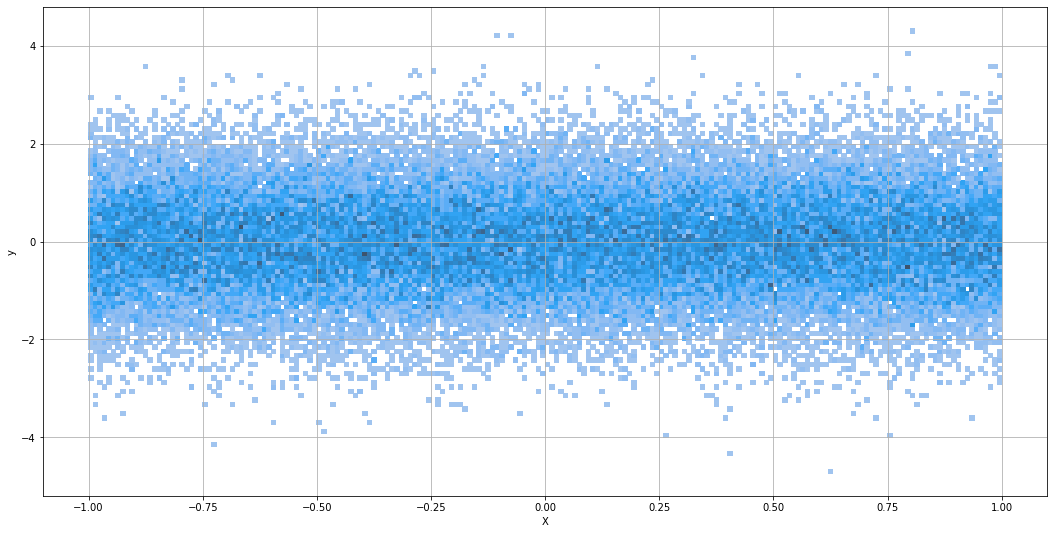

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

X = np.linspace(-1, 1, num=50_000)
# notice 0.05 << 1 (variance of y)
y = np.random.normal(X * 0.01)
df = pd.DataFrame({'X': pd.Series(X), 'y': pd.Series(y)})
ax = sns.histplot(data=df, x='X', y='y', bins=(200, 100))

ax.figure.set_figwidth(18)
ax.figure.set_figheight(9)
ax.grid()
plt.show()

X = X.reshape(-1, 1)

Above we have plotted a 2D histogram of $y$ vs $X$

The slight correlation $\bar y = 0.01 * X$ is completely unnoticeable by a naked eye. The blue bar seems perfectly horizontal.

However if we train a regression, the slope $0.01$ is easily detected.

Below we train an Extra-Trees regressor to predict $y$ based on $X$

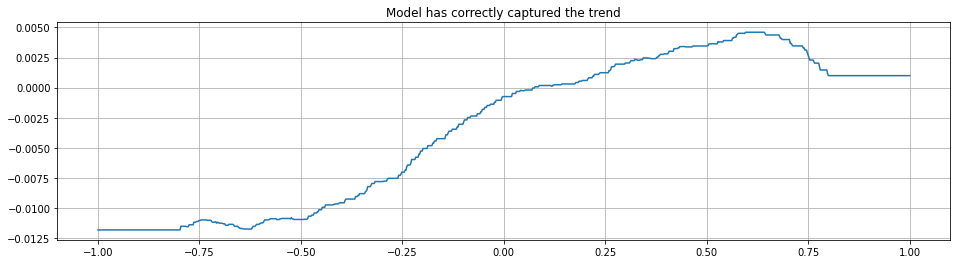

In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score

reg = ExtraTreesRegressor(
    min_samples_leaf=0.1
)
_ = reg.fit(X, y)

X_pred = np.linspace(-1, 1, num=1000)
y_pred = reg.predict(X_pred.reshape(-1, 1))
plt.plot(X_pred, y_pred)
plt.gca().grid()
plt.gca().set_title('Model has correctly captured the trend')
plt.gca().figure.set_figwidth(16)
plt.show()

As we can see, the model has learned the slope $0.01$, the learned curve has the slope $0.006$ which is close enough.

Let us see how model quality is measured by $R^2$ score in cross validation procedure.

In [ ]:
scores = cross_val_score(reg, X, y, scoring='r2')
print(f'r2 scores: {scores}')
print(f'r2 = {scores.mean():.6f} ± {scores.std():.6f}')

r2 scores: [-6.75983046e-05 -1.73809656e-04 -1.02523751e-04 -7.49891046e-05
 -5.08464309e-07]
r2 = -0.000084 ± 0.000056


$R^2$ score is negative.

One effect which contributes to negative $R^2$ score is lack of shuffling in cross-validation train and test sets. Such effect is demonstrated in a [notebook](https://colab.research.google.com/drive/1uoJTyNOTS-ClMI_meZQ1n-IT1Dfob8dg?usp=sharing) by @glemaitre, a contributor to scikit-learn library.

Let's see if adding shuffling will be enough to produce positive $R^2$

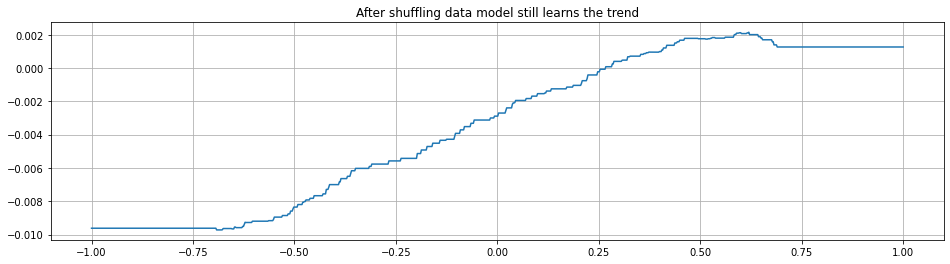

In [ ]:
from sklearn import utils

X_sh, y_sh = utils.shuffle(X, y)
reg_sh = ExtraTreesRegressor(
    min_samples_leaf=0.15
)
reg_sh.fit(X_sh, y_sh)

y_sh_pred = reg_sh.predict(X_pred.reshape(-1, 1))
plt.plot(X_pred, y_sh_pred)
plt.gca().grid()
plt.gca().figure.set_figwidth(16)
plt.gca().set_title('After shuffling data model still learns the trend')
plt.show()

In [ ]:
scores_sh = cross_val_score(reg_sh, X_sh, y_sh, scoring='r2')
print(f'r2 scores: {scores_sh}')
print(f'r2 = {scores_sh.mean():.6f} ± {scores_sh.std():.6f}')

r2 scores: [-3.89357993e-05 -3.60124354e-05 -2.09185703e-06 -1.46845875e-04
 -1.87368394e-04]
r2 = -0.000082 ± 0.000072


Still, $R^2 < 0$ and it is reliably so

In [ ]:
X_sh  # output X_sh to make sure it is not orderd from -1 to 1 anymore

array([[ 0.30442609],
       [-0.28162563],
       [-0.10170203],
       ...,
       [ 0.89615792],
       [ 0.66199324],
       [-0.7651953 ]])

The mechanism for negative $R^2$
---

We can see above, how cross-validation consistently outputs negative $R^2$ even despite the model is nearly perfect.

What is the mechanism for that?

To understand it, we need to look closely at the formula for $R^2$ and how it is applied during cross-validation.

$$R^2 = 1 - \frac{\Sigma(\hat y - y)^2}{\Sigma(\bar y - y)^2}$$

For the sake of simplicity, let us assume for the moment, that $y$ is completely independent from $X$, so instead of $\bar y = X \cdot 0.05$ let us consider $\bar y = X \cdot 0 = 0$

During cross-validation $R^2$ is calculated on test dataset, which is different from traning dataset. To reflect this, let us rewrite the formula above as follows:

$$R^2_{test} = 1 - \frac{\Sigma(\hat y_{test} - y_{test})^2}{\Sigma(\bar y_{test} - y_{test})^2}$$

Let us focus our attention on $\bar y_{test}$ in the denominator

Once we have chosen a test dataset, the average value on test dataset is inevtably going to be slightly different from the average value in the train dataset.

$$\bar y_{train} \neq \bar y_{test}$$

Remember, at the moment we are considering $\bar y = 0$ for any $X$, for the sake of simplicity.

So, the best our model can possibly do, is to learn to predict $\hat y = \bar y_{train}$

Suppose it did. What score is our ideal model getting on test dataset?

$$R^2_{test} = 1 - \frac{\Sigma(\hat y_{test} - y_{test})^2}{\Sigma(\bar y_{test} - y_{test})^2} = 1 - \frac{\Sigma(\bar y_{train} - y_{test})^2}{\Sigma(\bar y_{test} - y_{test})^2}$$

In statistics, there is this property of of average:

> For a collection of values, the sum of squared differences reaches minimum at the average of these values.

which means that for any value of $\bar y_{train}$

$$ \Sigma(\bar y_{train} - y_{test})^2 \ge \Sigma(\bar y_{test} - y_{test})^2$$ 

Which means we are guaranteed to get $R^2 \le 0$

What changes if $y$ does depend on $X$
---

Well, if the dependence is weak enough, we are essentially in the same situation. The model learns $\hat y = 0.01 \cdot X$ which in practical terms is almost identical to $\hat y = \bar X_{test} \approx 0$, because $0.01 \ll D(y) = 1$

Therefore we will still get negative $R^2$ in most attempts.

What is the solution
---

If we want to measure the quality of our model outside training dataset, we need to modify the formula for $R^2$, converting it to $R^2_{oos}$, the so called *R squared out of sample*.

The change is very simple

$$R^2 = 1 - \frac{\Sigma(\hat y_{test} - y_{test})^2}{\Sigma(\bar y_{test} - y_{test})^2}$$
$$ R^2_{oos} = 1 - \frac{\Sigma(\hat y_{test} - y_{test})^2}{\Sigma(\bar y_{train} - y_{test})^2}$$

replace $\bar y_{test}$ by $\bar y_{train}$


Below a function `cross_validate_r2oos(...)` is defined. It is based on `cross_validate(...)` from scikit-learn, and calculates $R^2_{oos}$ score

In [ ]:
from joblib import Parallel

from sklearn.model_selection._split import check_cv
from sklearn.utils.validation import check_consistent_length, _num_samples
from sklearn.utils.fixes import delayed
from sklearn.utils.metaestimators import _safe_split
from sklearn.base import clone, is_classifier


def cross_validate_r2oos(
  estimator, X, y=None, *, cv=None, n_jobs=None
):
    cv = check_cv(cv, y, classifier=is_classifier(estimator))
    parallel = Parallel(n_jobs=n_jobs, pre_dispatch="2*n_jobs")
    test_scores = parallel(
        delayed(_fit_and_score_r2oos)(
            clone(estimator), X, y, train, test
        )
        for train, test in cv.split(X, y, None)
    )

    return np.array(test_scores)


def _fit_and_score_r2oos(estimator, X, y, train, test):
    X_train, y_train = _safe_split(estimator, X, y, train)
    X_test, y_test = _safe_split(estimator, X, y, test, train)

    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)

    check_consistent_length(y_test, y_pred)
    assert _num_samples(y_pred) >= 2
    numerator = ((y_test - y_pred) ** 2).sum(axis=0, dtype=np.float64)
    denominator = (
        (y_test - np.average(y_train, axis=0)) ** 2
    ).sum(axis=0, dtype=np.float64)
    return 1 - numerator / denominator

Repeat cross-validation using $R^2_{oos}$

In [ ]:
scores_sh_oos = cross_validate_r2oos(reg_sh, X_sh, y_sh)
print(f'r2oos: {scores_sh_oos}')
print(f'r2oos {scores_sh_oos.mean():.6f} ± {scores_sh_oos.std():.6f}')

r2oos: [ 2.76327780e-05  3.74241653e-05 -9.99811397e-05  7.28863188e-05
  5.45120185e-05]
r2oos 0.000018 ± 0.000061


$R^2_{oos} > 0$ reliably, as intended.

To have $R^2 < 0$ reliably, while at the same time $R^2_{oos} > 0$, the size of dataset, the strength of dependency of $y$ on $X$, and the quality of model had to be all carefully chosen. It is natural and it is ok, because the effect  being discussed is subtle and depends on small variations of $\bar y_{test}$ between different test subsets.
\
\
With a great deal of effort, I've managed to find an article, where $R^2_{oos}$ is discussed in a at least somewhat clear and explicit way.

https://dachxiu.chicagobooth.edu/download/ML.pdf

See 1.8 Performance evaluation

Notice the formula in the paper has no subtration in the denominator. In general, subtration of $\bar y_{train}$ is assumed, but in this particular paper the authors make and additional step, specific to predicting stock returns. The know empirically, that predicting constant 0 is almost always better than the average on test dataset, so they replace $\bar y_{train}$ by 0.

UPDATE 2023-04-28

Found a good article which detailed study of $R^2_{oos}$

https://arxiv.org/pdf/2302.05131.pdf
